# Moment dynamics generation

(c) 2020 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import pickle

# Library that we will use to export lambdify functions
import cloudpickle

# Library we'll use to generate possible pairs of numbers
import itertools 

# Numerical workhorse
import numpy as np
import pandas as pd
import scipy as sp

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import ccutils

# Magic function to make matplotlib inline
%matplotlib inline

# This enables high resolution graphics inline. 
%config InlineBackend.figure_format = 'retina'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{{#1}^{\text{th}}}$
$\newcommand{dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{Km}{\bb{K}}$
$\newcommand{Rm}{\bb{R}_m}$
$\newcommand{Re}{\bb{R}_m'}$
$\newcommand{Gm}{\bb{\Gamma}_m}$
$\newcommand{Rp}{\bb{R}_p}$
$\newcommand{Gp}{\bb{\Gamma}_p}$

## General moment equation for simple repression architecture

For our system the master equation that describes the time evolution of the distribution is defined by either two or three differential equations, one for each state of the promoter such that

$$
P(m, p) = \sum_{s\in \text{states}} P_s(m, p),
\tag{1}
$$
where $s \in \{A, I, R\}$ defines the state $A =$ transcriptionally active, $I =$ transcriptionally inactive state, and $R =$ repressor bound. The third state is only include in the case where there is transcription factor present. Without loss of generality let's focus here on the three-state promoter. The results for the two-state promoter written in matrix notation look the same, only the definition of the matrices change. Let $\bb{P}(m, p) = (P_A(m, p), P_I(m, p), P_R(m, p))^T$ be the vector containing all distributions. Using this notation the system of PDEs that define the distribution is given by

$$
\dt{\bb{P}(m, p)} = \overbrace{
\left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right) \bb{P}(m, p)
}^{\text{exit state }m,p}\\
\overbrace{
+ \Rm \bb{P}(m-1, p) + \Gm (m + 1) \bb{P}(m+1, p)\\
+ \Rp (m) \bb{P}(m, p-1) + \Gm (p + 1) \bb{P}(m, p+1)
}^{\text{enter state }m,p},
\label{master_matrix}
\tag{2}
$$
where $\Km$ is the matrix defining transition rates between states, $\Rm$ and $\Gm$ are the matrices defining the production and degradation rates of mRNA respectively, and $\Rp$ and $\Gp$ are the equivalent matrices for the production and degradation of protein.

Given this birth-death process with three different states of the promoter if we compute a moment $\ee{m^x p^y}$ we need to compute

$$
\ee{m^x p^y} = \ee{m^x p^y}_A + \ee{m^x p^y}_I + \ee{m^x p^y}_R,
\tag{3}
$$
i.e. the moment at each of the states of the promoter. Let 
$\bb{\ee{m^x p^y}} = \left(\ee{m^x p^y}_A, \ee{m^x p^y}_I, \ee{m^x p^y}_R\right)^T$ be a vector containing all three moments. The moment PDE is then given by

$$
\dt{\bb{\ee{m^x p^y}}} = \dt{} \left[ \sum_m \sum_p m^x p^y \bb{P}(m,p)\right].
\tag{4}
$$

Applying this sum over all mRNA and protein counts we obtain

$$
\dt{\bb{\ee{m^x p^y}}} = 
\sum_m \sum_p \left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right)m^x p^y \bb{P}(m, p)\\
\overbrace{
+ \Rm \sum_m \sum_p m^x p^y \bb{P}(m-1, p) 
}^{1}
\overbrace{
+ \Gm \sum_m \sum_p (m + 1) m^x p^y \bb{P}(m+1, p)
}^{2}\\
\overbrace{
+ \Rp \sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) 
}^{3}
\overbrace{
+ \Gm \sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1)
}^{4}.
\tag{5}
$$
Each of the numbered terms have stereotypical "tricks" to simplify them. Let's list them (derivation left elsewhere):

$$
1: m' \equiv m - 1\\
\Rightarrow
\sum_m \sum_p m^x p^y \bb{P}(m-1, p) = 
\sum_{m'} \sum_p (m' + 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{(m+1)^x p^y}},
\tag{6}
$$

$$
2: m' \equiv m + 1\\
\Rightarrow
\sum_m \sum_p (m + 1) m^x p^y \bb{P}(m + 1, p) = 
\sum_{m'} \sum_p m' (m' - 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{m (m - 1)^x p^y}},
\tag{7}
$$

$$
3: p' \equiv p - 1\\
\Rightarrow
\sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) =
\sum_m \sum_{p'} m^{x + 1} (p' + 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^{x + 1} (p +  1)^{y}}},
\tag{8}
$$

$$
4: p' \equiv p + 1\\
\Rightarrow
\sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1) =
\sum_m \sum_{p'} p' m^x (p' - 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^x p (p - 1)^y}}.
\tag{9}
$$

Given these tricks we can write a **general** form for the moment PDE given by
$$
\dt{\bb{\ee{m^x p^y}}} =
\Km \bb{\ee{m^x p^y}} +\\
\Rm \left[ \bb{\ee{(m+1)^x p^y}} - \bb{\ee{m^x p^y}} \right] +\\
\Gm \left[ \bb{\ee{m (m - 1)^x p^y}} - \bb{\ee{m^{x + 1} p^y}} \right] +\\
\Rp \left[ \bb{\ee{m^{x + 1} (p +  1)^{y}}} - \bb{\ee{m^{x+1} p^y}} \right] +\\
\Gp \left[ \bb{\ee{m^x p (p - 1)^y}} - \bb{\ee{m^x p^{y+1}}} \right]
\tag{10}
$$

It can be shown that all moments $\bb{\ee{m^x p^y}}$ depend only on moments $\bb{\ee{m'^x p'^y}}$ such that two conditions are satisfied:

\begin{equation}
  \begin{aligned}
    &1) y' \leq y,\\
  &2) x' + y' \leq x + y.
  \end{aligned}
  \tag{11}
\end{equation}

What this implies is that this system has no moment closure problem since all moments depend only on lower degree moments. We can use this to our advantage to generate a general moment dynamics equation.

### General moment dynamics

Let $\bb{\mu^{(x, y)}}$ be a vector containing all moments up to $\bb{\ee{m^x p^y}}$ for all promoter states. This is

$$
\bb{\mu^{(x, y)}} = \left[ \bb{\ee{m^0 p^0}}, \bb{\ee{m^1 p^0}}, \ldots \bb{\ee{m^x p^y}} \right]^T.
\tag{12}
$$
Explicitly for the three-state promoter this vector looks like

$$
\bb{\mu^{(\bb{x, y})}} = \left[ \ee{m^0 p^0}_A, \ee{m^0 p^0}_I, \ee{m^0 p^0}_R, \ldots,
                 \ee{m^x p^y}_A, \ee{m^x p^y}_I, \ee{m^x p^y}_R \right]^T.
\tag{13}
$$
Given this definition we can define the general moment dynamics in matrix notation as

$$
\dt{\mu^{(\bb{x, y})}} = \bb{A \mu^{(\bb{x, y})}} + \bb{\nu},
\tag{14}
$$
where $\bb{A}$ is a square matrix that contains all the connections in the network, i.e. the numeric coefficients that relate each of the moments, and $\bb{\nu}$ is a vector of constant terms.


## Using `sympy` to compute moments

The objective of this notebook is to generate the matrix $\bb{A}$ and the vector $\bb{\nu}$ from the general moment equation derived earlier.

### Define general moment equation.

Let's define the `sympy` variables that we will need for the moment equation.

First we define the variables for the matrices.

In [3]:
# Define the matrices involved in the general moment equation
Km = sympy.Symbol('{\mathbf{K}}')  # State transition matrix
Rm, Gm = sympy.symbols('{\mathbf{R}_m} {\mathbf{\Gamma}_m}')  # mRNA matrices
Rp, Gp = sympy.symbols('{\mathbf{R}_p} {\mathbf{\Gamma}_p}')  # protein matrices

Km, Rm, Gm, Rp, Gp

Let's define the variables that go into the matrices.

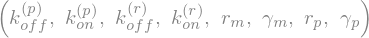

In [4]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^{(p)}} {k_{on}^{(p)}}')
kr_off, kr_on = sympy.symbols('{k_{off}^{(r)}} {k_{on}^{(r)}}')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')
rp, gp = sympy.symbols('r_p gamma_p')

kp_off, kp_on, kr_off, kr_on, rm, gm, rp, gp

Now we define the mRNA and exponent variables

In [5]:
# Define the mRNA and protein variables
m, p, = sympy.symbols('{\mathbf{m}} {\mathbf{p}}')
x, y = sympy.symbols('{\mathbf{x}} {\mathbf{y}}')

# As an extra variable let's define the time t
t = sympy.symbols('t')

# Let's also define the non-vector varirables for
# mRNA and protein
mm, pp = sympy.symbols('m p')

m**x, p**y, t, mm, pp

Let's now define the right hand side of the general moment equation.

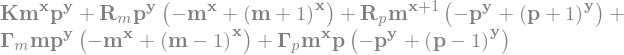

In [6]:
# Defining the general master moment equation
master_moment = Km * (m**x * p**y) +\
Rm * (p**y) * ((m + 1)**x - m**x) +\
Gm * (m * p**y) * ((m - 1)**x - m**x) +\
Rp * m**(x + 1) * ((p + 1)**y - p**y) +\
Gp * (m**x * p) * ((p - 1)**y - p**y)

master_moment

Having defined this equation now all we need to do to obtain any moment equation is to substitute $\bb{x}$ and $\bb{y}$. As a sanity check let's look at some examples that we already know the answer. Let's look at the first mRNA moment.

In [7]:
# Define the first mRNA moment <m> equation
master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

The term with $\Rm$ only is actually $\Rm \bb{m}^0$ which is exactly what one obtains when solving for this particular moment.

Let's look now at the second protein moment.

In [8]:
master_moment.subs([[x, 0], [y, 2]]).factor([m, p])

This is again the answer one gets performing the calculation specifically for this moment.

### Extract coefficients of moment polynomial equation.

Let's now define a function that given an expression for a moment it returns a dictionary with all the coefficients of each of the elements in the equation. For example for the previous example of the second protein moment it should return something of the form

$$
\{
\bb{p}^2 : (\Km - 2\Gm), \;\;
\bb{p} : \Gp, \;\;
\bb{mp} : 2\Rp, \;\;
\bb{m} : \Rp
\}
\tag{15}
$$

This will be useful for when we substitute the matrices and vectors to solve the linear system.

In [9]:
def coeff_dictionary(eq):
    '''
    Returns a dictionary with each of the coefficients for a given eqent
    equation.

    Parameter
    ---------
    eq : sympy expression.
        Sympy expression for the eqent equation

    Returns
    -------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients of each of the elements
        in the polynomial eqent equation
    '''
    # Find the degree of the eqent for each of the variables
    if eq.has(m):
        m_degree = sympy.Poly(eq).degree(m)
    else:
        m_degree = 0
    if eq.has(p):
        p_degree = sympy.Poly(eq).degree(p)
    else:
        p_degree = 0
    
    return {m**x * p**y: eq.coeff(m**x * p**y).\
            subs([[m, 0], [p, 0]])
            for x in range(m_degree + 1)
            for y in range(p_degree + 1)}

Let's test the function.

In [10]:
p2_dict = coeff_dictionary(master_moment.subs([[x, 0], [y, 2]]).factor([m, p]))
p2_dict

### Substituting definition of matrices

We now have the functions to use the general moment equation to obtain the coefficients for a specific moment. In order to assemble the matrix $\bb{A}$ we need to substitute the definition of the matrices $\Km$, $\Rm$, $\Gm$, $\Rp$, and $\Gp$ to convert from the matrix notation to the actual matrix.

**NOTE:** on `sympy` getting to substitute a term like $(\Km - \Gm)$ with the corresponding matrices and then actually doing the subtraction is unfortunately very convoluted. If you want to reproduce this make sure you follow the instructions.

In [11]:
def coeff_subs(coeff_dict, Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat):
    '''

    Parameters
    ----------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients associated with each of the
        moments in the moment equation.
    Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat: 2D sympy matrices.
        Sympy matrices that define the master equation.
        Km_mat : transition between states
        Rm_mat : mRNA produciton
        Gm_mat : mRNA degradation
        Rp_mat : protein production
        Gp_mat : protein degradation

    Returns
    -------
    mom_mat_dict : dictionary.
        Dictionary containing each of the substitutted coefficients into matrices
    '''
    # Initialize dictionary to save the matrices
    mom_mat_dict = dict()

    # Loop through each of the coefficients and compute the operation
    # NOTE: It is quite tricky to get it to work on sympy
    for key, value in coeff_dict.items():
        # Extract arguments for the item
        args = value.args

        # Check each of the possible cases

        # 1. args is empty and value is zero :
        # That is a term of the form {key : 0}
        # Generate a matrix of zeros
        if (len(args) == 0) & (value == 0):
            mom_mat_dict[key] = sympy.zeros(*Km_mat.shape)

        # 2. args is empty and value is not zero :
        # That is the case where the term is a single matrix
        # Substitute that value with the actual definition of the matrix
        elif (len(args) == 0) & (value != 0):
            mom_mat_dict[key] = value.subs([[Km, Km_mat],
                                            [Rm, Rm_mat],
                                            [Gm, Gm_mat],
                                            [Rp, Rp_mat],
                                            [Gp, Gp_mat]])

        # 3. args is not empty but one of the terms is an integer :
        # That is the case where we have Number * Matrix.
        # substitute the matrix and multiply it by the number
        elif (len(args) != 0) & (any([x.is_Number for x in args])):
            # Substitute value
            term_list = [x.subs([[Km, Km_mat],
                                 [Rm, Rm_mat],
                                 [Gm, Gm_mat],
                                 [Rp, Rp_mat],
                                 [Gp, Gp_mat]]) for x in value.args]
            # Multiply matrix by constant and register case
            mom_mat_dict[key] = np.prod(term_list)

        # 4. args is not empty and non of the elements is an integer :
        # Substitute matrices and reduce to single matrix.
        else:
            term_list = [x.subs([[Km, Km_mat],
                                 [Rm, Rm_mat],
                                 [Gm, Gm_mat],
                                 [Rp, Rp_mat],
                                 [Gp, Gp_mat]]) for x in value.args]

            # Perform a second round of checking. Elements that have for example
            # Number * Matrix are not explicitly multiplied. For this we will use
            # np.prod by splitting the terms again into its arguments and
            # multiplying the the arguments
            for i, term in enumerate(term_list):
                if len(term.args) == 2:
                    term_list[i] = np.prod(term.args)

            # Add the matrices. In order to do so:
            # the sum function has an optional "start" argument so you can
            # initialize it with a "zero object" of the kind you are adding.
            # In this case, with a zero matrix.
            mom_mat_dict[key] = sum(term_list, sympy.zeros(*Km_mat.shape))
            
    return mom_mat_dict

Let's test the matrix by defining the corresponding matrices for the three-state system.

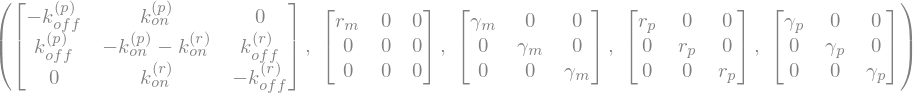

In [12]:
# Define the rate constant matrix
Km_reg = sympy.Matrix([[-kp_off, kp_on, 0], 
                         [kp_off, -(kp_on + kr_on), kr_off],
                         [0, kr_on, -kr_off]])
# Define the production matrix
Rm_reg = sympy.Matrix([[rm, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])
# Define the degradation matrix
Gm_reg = sympy.Matrix([[gm, 0, 0],
                       [0, gm, 0],
                       [0, 0, gm]])

# Define the production matrix
Rp_reg = sympy.Matrix([[rp, 0, 0],
                       [0, rp, 0],
                       [0, 0, rp]])

# Define the production matrix
Gp_reg = sympy.Matrix([[gp, 0, 0],
                       [0, gp, 0],
                       [0, 0, gp]])


Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg

Having defined these matrices, let's substitute it into the second-moment example we have been working with so far.

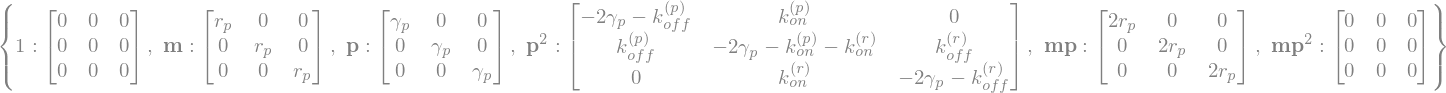

In [13]:
p2_coeff_dict = coeff_subs(p2_dict, Km_reg, Rm_reg, Gm_reg,
                           Rp_reg, Gp_reg)

p2_coeff_dict

### Systematically finding the moments necessary to solve for $\bb{\ee{m^x p^y}}$

We established that a moment of the form $\bb{\ee{m^x p^y}}$ depends on lower moments that satisfy two conditions. We need to define a function that given the largest moment $\bb{\ee{m^x p^y}}$ to be included in the matrix it finds all of the moments $\bb{\ee{m^{x'} p^{y'}}}$ that satisfy such conditions.

In [14]:
def expo_pairs(m_expo, p_expo):
    '''
    Finds all of the pairs of exponents x', y' that are necessary to compute the
    moment <m**m_expo * p**p_expo> that satisfy the necessary conditions:
    1) y' <= p_expo
    2) x' + y' <= m_expo + p_expo
    Parameters
    ----------
    m_expo, p_expo: int.
        Exponents of the highest moment to be included in the system.
        m_expo corresponds to the mRNA exponent
        p_expo corresponds to the protein exponent
        
    Returns
    -------
    pairs : list.
        List of sorted exponent pairs necessary for the computation
    NOTE: The sorting (which is not a necessary feature) given the general
    form of the equation only works up to the moment <m**0 * p**p_expo>.
    Any moment with x'>0 and y'=p_expo will be out of order appended at
    the end of the list.
    '''
    # Find all possible pair of exponents that satisfy
    # x' + y' <= m_expo + p_expo
    expo_pairs = list(itertools.permutations(range(m_expo + p_expo + 1), 2))

    # Add the (num, num) pair that are not being included
    expo_pairs = expo_pairs + [tuple([s, s]) for s in 
                               range(max([m_expo, p_expo]) + 1)]

    # Remove pairs that do not satisfy the condition
    # y' <= p_expo
    expo_pairs = [s for s in expo_pairs if s[1] <= p_expo]

    # Remove pairs that do not satisfy the condition
    # x' <= m_expo + 1
#     expo_pairs = [x for x in expo_pairs if x[0] <= m_expo + 1]

    # # Remove pairs that do not satisfy the condition
    # x' + y' <= m_expo + p_expo
    expo_pairs = [s for s in expo_pairs if sum(s) <= m_expo + p_expo]

    ##  Moment sorting ##
    # Initialize list to append sorted moments
    expo_sorted = list()

    # Append mRNA moments
    mRNA_mom = sorted([s for s in expo_pairs if s[1] == 0])
    expo_sorted.append(mRNA_mom)

    # Find each protein moment
    protein_mom = sorted([s for s in expo_pairs if (s[0] == 0) & (s[1] != 0)])

    # Loop through each protein moment and find the cross correlations
    # associated with it
    for pr in protein_mom:
        cross_corr = sorted([s for s in expo_pairs
                             if (s[0] > 0) & (s[1] > 0) & (sum(s) == pr[1])],
                            reverse=True)
        # append it to the list
        expo_sorted.append(cross_corr)
        expo_sorted.append([pr])

    expo_sorted = list(itertools.chain.from_iterable(expo_sorted))

    # Append the other terms that are missing
    missing = [s for s in expo_pairs if s not in expo_sorted]
    
    return expo_sorted + missing

Let's test the function by finding the moments that would be needed to obtain the second moment of the protein distribution.

In [15]:
# Define exponents for highest moment to be inferred
m_expo, p_expo = 0, 2

# Find the list of moments that need to be computed
expo_pairs(m_expo, p_expo)

These are indeed the necessary moments to compute the protein second moment. Now that we can generate this list we are able to build our matrix $\bb{A}$ by iteratively substitute these exponents on the general moment equation and fill the corresponding entries on the matrix.

In [16]:
def A_matrix_gen(m_expo, p_expo, Km, Rm, Gm, Rp, Gp):
    '''
    Generates the matrix A to compute the moment dynamics of the form
    dµ/dt = A * µ
    It is basically a collection of the coefficients that go along
    each moment.
    
    Parameters
    ----------
    m_expo, p_expo: int.
        Exponents of the highest moment to be included in the system.
        m_expo corresponds to the mRNA exponent
        p_expo corresponds to the protein exponent
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states. 
    
    Returns
    -------
    A_matrix : 2D-array.
        Sympy matrix containing all of the coefficients to compute the 
        moment dynamics.
    exponents : list.
        List of exponents as they are computed in the dynamics
    '''
    # Define number of dimensions
    n_dim = Km.shape[0]
    
    # Find exponents of moments needed to be computed
    exponents = expo_pairs(m_expo, p_expo)

    # Initalize matrix A
    A_matrix = sympy.Matrix(np.zeros([len(exponents) * n_dim,
                                      len(exponents) * n_dim]))

    # Generate dictionary that saves position of each moment
    # on the matrix
    idx_dict = {e: [i * n_dim, (i * n_dim) + (n_dim)] for
                i, e in enumerate(exponents)}

    # Loop through moments to subsittute exopnents into
    # general moment equation
    for i, (mexp, pexp) in enumerate(exponents):
        # Substitute exponents into general moment equation
        mom_eq = master_moment.subs([[x, mexp], [y, pexp]]).\
                               factor([m, p])
        # Obtain coefficients of equation
        mom_coeff = coeff_dictionary(mom_eq)
        # Substitute coefficients with matrices
        mom_subs = coeff_subs(mom_coeff, Km, 
                              Rm, Gm, Rp, Gp)
        # Find row index on matrix A for substitutions
        row_idx = idx_dict[(mexp, pexp)]
        # Loop through coefficients to make substitutions
        for key, value in mom_subs.items():
            # Find exponents of the moment
            if key.has(m):
                m_degree = sympy.Poly(key).degree(m)
            else:
                m_degree = 0
            if key.has(p):
                p_degree = sympy.Poly(key).degree(p)
            else:
                p_degree = 0

            # Check if moment included in mom_sub.
            # Sometimes extra moments with no values are added
            if (m_degree, p_degree) in exponents:
                # Find index for columns
                col_idx = idx_dict[(m_degree, p_degree)]
                # Substitute values in corresponding entries
                A_matrix[row_idx[0]:row_idx[1], 
                         col_idx[0]:col_idx[1]] = value
                
    return A_matrix, exponents

Let's test the function for a small case that we can visualize. Let's build the matrix to compute up to the first protein moment

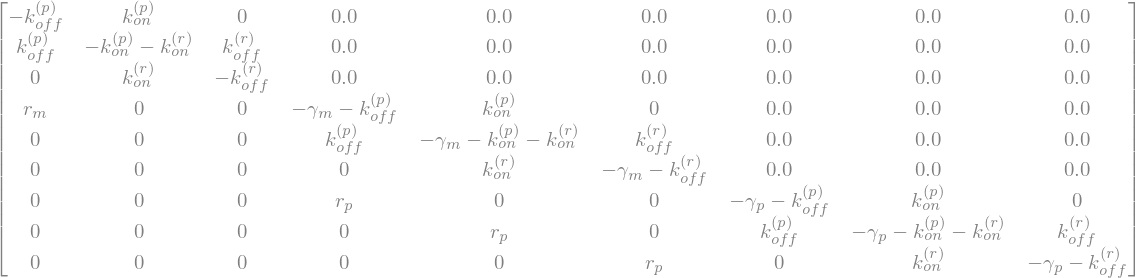

In [17]:
# Generate matrix for the first protein moment
A_mat, expo = A_matrix_gen(0, 1, Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg)

A_mat

Having built this matrix let's now generate $\bb{A}$ for the following cases:
1. unregulated promoter:

    A. mRNA up to $\bb{\ee{m^6}}$
    
    B. protein up to $\bb{\ee{p^6}}$

2. regulated promoter:

    A. mRNA up to $\bb{\ee{m^6}}$
    
    B. protein up to $\bb{\ee{p^6}}$

We will save the results as a `lambdify` function that we can import into other notebooks.

Let's first define the matrices for the unregulated case

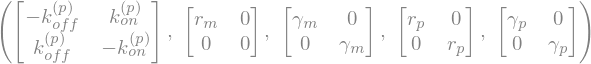

In [18]:
# Define the rate constant matrix
Km_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = sympy.Matrix([[rm, 0], 
                         [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = sympy.Matrix([[gm, 0],
                         [0, gm]])

# Define the protein production matrix
Rp_unreg = sympy.Matrix([[rp, 0], 
                         [0, rp]])
# Define the protein degradation matrix
Gp_unreg = sympy.Matrix([[gp, 0],
                         [0, gp]])


Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg

Now let's generate the dynamics for the unregulated case.

In [19]:
# Generate mRNA dynamics
# Generate matrix for the first protein moment
A_m_unreg, expo_m = A_matrix_gen(6, 0, Km_unreg, 
                                 Rm_unreg, Gm_unreg, 
                                 Rp_unreg, Gp_unreg)

# Define array containing variables
var = [kp_on, kp_off, rm, gm]

# Generate labdify function
A_m_unreg_lamdify = sympy.lambdify(var, A_m_unreg)

# Export function into file
with open('./pkl_files/two_state_mRNA_dynamics_matrix.pkl', 'wb') as file:
    cloudpickle.dump(A_m_unreg_lamdify, file)
    cloudpickle.dump(expo_m, file)

# Generate protein dynamics
# Generate matrix for the first protein moment
A_p_unreg, expo_p = A_matrix_gen(0, 6, Km_unreg, 
                               Rm_unreg, Gm_unreg, 
                               Rp_unreg, Gp_unreg)

# Define array containing variables
var = [kp_on, kp_off, rm, gm, rp, gp]

# Generate labdify function
A_p_unreg_lamdify = sympy.lambdify(var, A_p_unreg)

# Export function into file
with open('./pkl_files/two_state_protein_dynamics_matrix.pkl', 'wb') as file:
    cloudpickle.dump(A_p_unreg_lamdify, file)
    cloudpickle.dump(expo_p, file)

Let's repeat these calculations for the regulated case

In [20]:
# Generate mRNA dynamics
# Generate matrix for the first protein moment
A_m_reg, expo_m = A_matrix_gen(6, 0, Km_reg, 
                               Rm_reg, Gm_reg, 
                               Rp_reg, Gp_reg)

# Define array containing variables
var = [kr_on, kr_off, kp_on, kp_off, rm, gm]

# Generate labdify function
A_m_reg_lamdify = sympy.lambdify(var, A_m_reg)

# Export function into file
with open('./pkl_files/three_state_mRNA_dynamics_matrix.pkl', 'wb') as file:
    cloudpickle.dump(A_m_reg_lamdify, file)
    cloudpickle.dump(expo_m, file)

# Generate protein dynamics
# Generate matrix for the first protein moment
A_p_reg, expo_p = A_matrix_gen(0, 6, Km_reg, 
                               Rm_reg, Gm_reg, 
                               Rp_reg, Gp_reg)

# Define array containing variables
var = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp]

# Generate labdify function
A_p_reg_lamdify = sympy.lambdify(var, A_p_reg)

# Export function into file
with open('./pkl_files/three_state_protein_dynamics_matrix.pkl', 'wb') as file:
    cloudpickle.dump(A_p_reg_lamdify, file)
    cloudpickle.dump(expo_p, file)

# Numerical integration of moments

Having generated the matrix $\bb{A}$ we can now numerically integrate the moment dynamics 
$$
\dt{\bb{\mu^{(\bb{x,y})}}} = \bb{A \mu^{(\bb{x, y})}}.
\tag{16}
$$

First we read the parameter values inferred for the unregulated promoter assuming a single promoter at steady state.

In [21]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradatino rates
gp = 1 / (60 * 100) # sec^-1
rp = 500 * gp # sec^-1

Let's now define the function to feed to the `scipy odeint` function that computes the right-hand side of the moment dynamics.

In [22]:
# Read mRNA matrix 
with open('./pkl_files/two_state_mRNA_dynamics_matrix.pkl', 'rb') as file:
    A_mat_unreg_lam = cloudpickle.load(file)
    expo = cloudpickle.load(file)

# Substitute value of parameters on matrix
A_mat_unreg = A_mat_unreg_lam(kp_on, kp_off, rm, gm)

def dmdt_unreg(mom, t):
    '''
    Function to integrate 
    dµ/dt = Aµ
    for the unregulated promoter using the scipy.integrate.odeint
    routine
    
    Parameters
    ----------
    mom : array-like
        Array containing all of the moments included in the matrix
        dynamics A.
    t : array-like
        Time array
    
    Returns
    -------
    Right hand-side of the moment dynamics
    '''
    return np.dot(A_mat_unreg, mom)

Now we can define the time array to perform the integration along with the initial conditions to integrate the moment dynamics.

In [23]:
# Define time on which to perform integration
t = np.linspace(0, 20 * 60, 301)

# Define initial conditions
mom_init = np.array([0] * len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Integrate dynamics
mom_dynamics = sp.integrate.odeint(dmdt_unreg, mom_init, t)


## Save results in tidy dataframe  ##
# Define promoter states names
states = ['P', 'E']
# Define names of columns
names = ['m{0:d}p{1:d}'.format(*x) + s for x in expo 
         for s in states]

# Save as data frame
df_m_unreg = pd.DataFrame(mom_dynamics, columns=names)
# Add time column
df_m_unreg = df_m_unreg.assign(t_sec = t, t_min = t / 60)

df_m_unreg.head()

,m0p0P,m0p0E,m1p0P,m1p0E,m2p0P,m2p0E,m3p0P,m3p0E,m4p0P,m4p0E,m5p0P,m5p0E,m6p0P,m6p0E,t_sec,t_min
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.659941,0.340059,1.493616,0.364540,4.888498,0.901562,19.407399,2.876893,89.243886,11.155311,461.904592,50.250121,2640.832786,255.509555,4.0,0.066667
2,0.460954,0.539046,2.003875,1.071424,10.887711,4.083923,68.340001,19.887471,480.223792,115.148767,3705.985927,760.370649,31000.202542,5583.922193,8.0,0.133333
3,0.344516,0.655484,2.103787,1.810708,15.580350,9.076318,130.500223,57.722605,1203.686080,431.883456,12034.052740,3650.750231,129018.530237,34039.854937,12.0,0.200000
4,0.276382,0.723618,2.057844,2.471903,18.765197,15.023681,192.706414,115.706961,2164.859611,1043.653429,26185.883182,10583.813397,337581.439606,117837.242540,16.0,0.266667


Let's look at the dynamics of the first moment. We expect this to reach the steady state value given by
$$
\ee{m} = {r_m \over \gm} \left( {\kpon \over \kpon + \kpoff} \right).
\tag{17}
$$

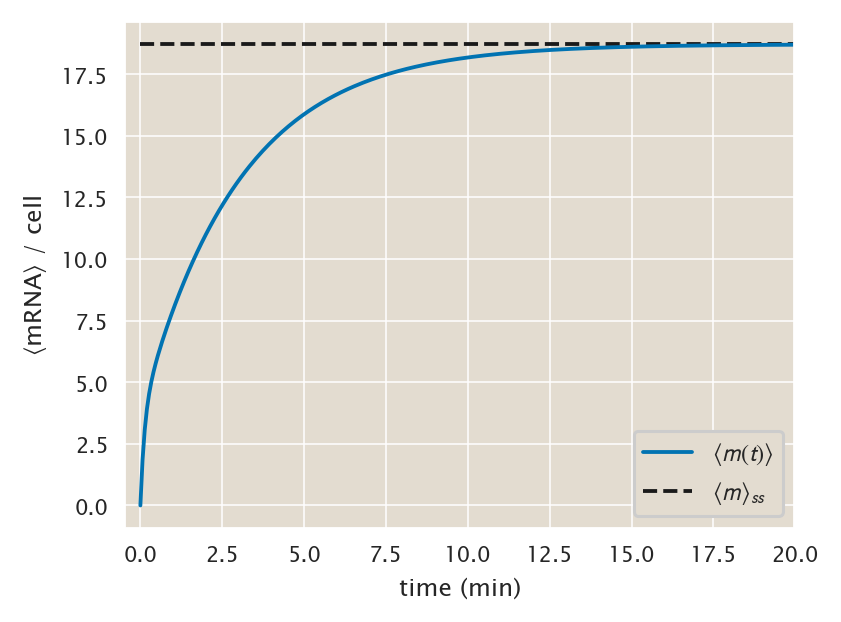

In [24]:
# Compute steady state value
m_ss = rm / gm * (kp_on / (kp_on + kp_off))

# Extract index for first and second moment
first_mom_names = [x for x in df_m_unreg.columns if 'm1p0' in x]

# Compute the mean mRNA copy number
m_mean = df_m_unreg.loc[:, first_mom_names].sum(axis=1)

# Initialize figure
fig = plt.figure(figsize=(4, 3))

# Plot mean mRNA
plt.plot(df_m_unreg.t_min, m_mean, 
         label=r'$\left\langle m(t) \right\rangle$')

# Plot steady state
plt.hlines(m_ss, df_m_unreg.t_min.min(),
           df_m_unreg.t_min.max(),
           linestyle='--', 
           label=r'$\left\langle m \right\rangle_{ss}$')

# Add legend
plt.legend(loc='lower right')

# Change axis extension
plt.xlim([-.5, 20])
# label axis
plt.xlabel('time (min)')
plt.ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$ / cell')

plt.tight_layout()

The dynamics converge to the expected steady state value, showing that at least for $\ee{m}$ we obtain the expected result.

Let's now define a function that takes in general any matrix $\bb{A}$, a time array, initial conditions, and returns the dynamics in a tidy dataframe.

In [25]:
def dmomdt(A_mat, expo, t, mom_init, states=['E', 'P', 'R']):
    '''
    Function to integrate 
    dµ/dt = Aµ
    for any matrix A using the scipy.integrate.odeint
    function
    
    Parameters
    ----------
    A_mat : 2D-array
        Square matrix defining the moment dynamics
    expo : array-like
        List containing the moments involved in the 
        dynamics defined by A
    t : array-like
        Time array in seconds
    mom_init : array-like. lenth = A_mat.shape[1]
    states : list with strings. Default = ['E', 'P', 'R']
        List containing the name of the promoter states
    Returns
    -------
    Tidy dataframe containing the moment dynamics
    '''
    # Define a lambda function to feed to odeint that returns
    # the right-hand side of the moment dynamics
    def dt(mom, time):
        return np.dot(A_mat, mom)
    
    # Integrate dynamics
    mom_dynamics = sp.integrate.odeint(dt, mom_init, t)

    ## Save results in tidy dataframe  ##
    # Define names of columns
    names = ['m{0:d}p{1:d}'.format(*x) + s for x in expo 
             for s in states]

    # Save as data frame
    df = pd.DataFrame(mom_dynamics, columns=names)
    # Add time column
    df = df.assign(t_sec = t, t_min = t / 60)
    
    return df

Let's test this function by computing the unregulated protein dynamics.

In [26]:
# Read protein ununregulated matrix 
with open('./pkl_files/two_state_protein_dynamics_matrix.pkl', 'rb') as file:
    A_mat_unreg_lam = cloudpickle.load(file)
    expo = cloudpickle.load(file)

# Substitute value of parameters on matrix
A_mat_unreg = A_mat_unreg_lam(kp_on, kp_off, rm, gm, rp, gp)

# Define initial conditions
mom_init = np.array([0] * len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Define time on which to perform integration
t = np.linspace(0, 500 * 60, 2000)

# Define promoter states
states = ['P', 'E']

# Integrate dynamics
df = dmomdt(A_mat_unreg, expo, t, mom_init, states)

# Take a look at the resulting dataframe
df.head()

,m0p0P,m0p0E,m1p0P,m1p0E,m2p0P,m2p0E,m3p0P,m3p0E,m4p0P,m4p0E,...,m3p3P,m3p3E,m2p4P,m2p4E,m1p5P,m1p5E,m0p6P,m0p6E,t_sec,t_min
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
1,0.290050,0.709950,2.075003,2.317273,18.096207,13.500064,177.707734,99.653272,1910.823426,862.137474,...,1.019576e+05,5.470264e+04,9.188870e+04,5.913926e+04,9.056480e+04,7.092658e+04,9.701996e+04,9.412560e+04,15.007504,0.250125
2,0.194978,0.805022,1.862248,4.063813,23.921085,36.057456,359.797968,410.479192,6011.375271,5492.258641,...,5.081123e+06,5.533142e+06,7.661525e+06,1.006979e+07,1.216950e+07,1.950664e+07,2.034663e+07,4.022157e+07,30.015008,0.500250
3,0.182246,0.817754,1.909144,5.092269,27.802650,54.797810,490.382834,764.432627,9863.377203,12658.041675,...,4.175629e+07,6.644891e+07,9.164106e+07,1.757869e+08,2.102168e+08,4.890169e+08,5.043670e+08,1.430709e+09,45.022511,0.750375
4,0.180542,0.819458,2.049678,5.896106,32.229689,71.262453,618.572091,1116.776396,13689.090548,20872.732661,...,1.721680e+08,3.382274e+08,5.047451e+08,1.188832e+09,1.547368e+09,4.379814e+09,4.963345e+09,1.690687e+10,60.030015,1.000500


Let's now take a look at the first moment of both mRNA and protein. Here we will plot the first moment dynamics normalized by the expected steady-state value. This will allow us to 1) compare both dynamics on the same plot, and 2) assess if the integration is converging to the expected value.

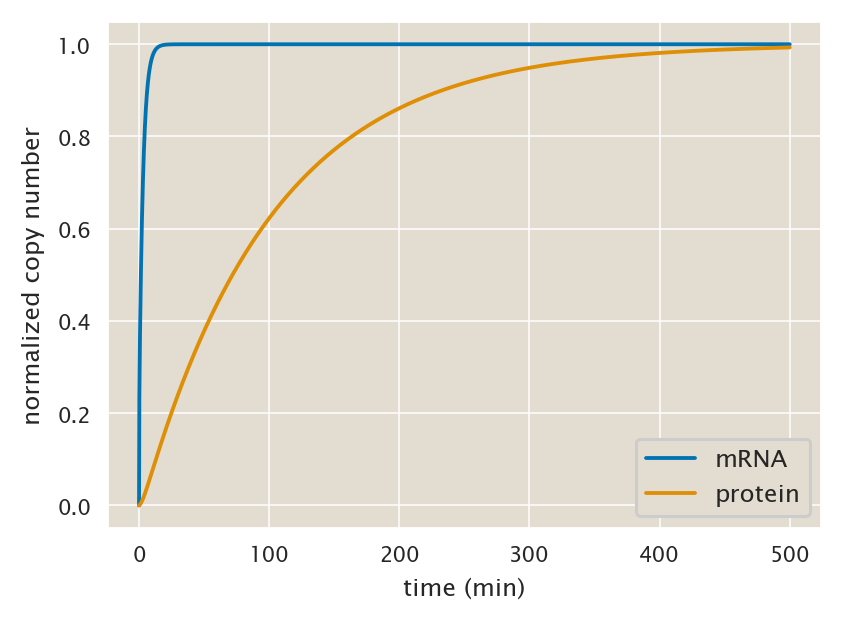

In [27]:
# Compute steady state value
m_ss = rm / gm * (kp_on / (kp_on + kp_off))
p_ss = rp / gp * m_ss

# Extract index for first and second moment
m1p0_names = [x for x in df.columns if 'm1p0' in x]
m0p1_names = [x for x in df.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
m_mean = df.loc[:, m1p0_names].sum(axis=1)
p_mean = df.loc[:, m0p1_names].sum(axis=1)

# Initialize figure
fig = plt.figure(figsize=(4, 3))

# Plot mean mRNA
plt.plot(df.t_min, m_mean / m_ss, 
         label='mRNA')

# Plot mean protein
plt.plot(df.t_min, p_mean / p_ss, 
         label=r'protein')

# Add legend
plt.legend(loc='lower right')

# Change axis extension
# label axis
plt.xlabel('time (min)')
plt.ylabel('normalized copy number')

plt.tight_layout()

We can see that given the difference in degradation rates between the mRNA and the protein, the protein dynamics take much longer to reach the steady state. This right away raises the question of how does the cell cycle affect the dynamics since the content of the cell is effectively halved every time the cell divides. In the next section we will explore this more explicitly.